####  dataset https://www.consumerfinance.gov/data-research/
https://www.consumerfinance.gov/data-research/consumer-complaints/

What the consumers were complaining in the financial product and service market? 
Data from these complaints help us understand the financial marketplace and protect consumers.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import Window
from pyspark.sql import SQLContext
#from pyspark.sql.functions import col, udf
import pyspark.sql.functions as F
from pyspark.sql.functions import split, explode
#from pyspark.sql.functions import regexp_replace, trim, col, lower
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, TimestampType,ArrayType
from pyspark.ml.feature import Tokenizer, RegexTokenizer

NLP related installation and import

In [0]:
#word cloud
!pip install wordcloud
from wordcloud import WordCloud 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [0]:
#!/bin/bash
!pip install nltk
!pip install --upgrade pip
!nltk.downloader all

import nltk
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')
#stopwords = set(STOPWORDS) 
stopwords = nltk.corpus.stopwords.words('english')
english_words = set(nltk.corpus.words.words())
#########
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data] Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data] /root/nltk_data...
[nltk_data] Package averaged_perceptron_tagger is already up-to-
[nltk_data] date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data] /root/nltk_data...
[nltk_data] Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Package words is already up-to-date!
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data] Package ieer is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!

In [0]:
#palette for seaborn
palette_colors = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878',
                    '#A040A0', '#F8D030','#E0C068','#EE99AC','#C03028', 
                    '#F85888', '#B8A038','#705898','#98D8D8','#7038F8']

#### 1.1 Data acquisition
- download [json format datasource](http://files.consumerfinance.gov/ccdb/complaints.json.zip) to local storage and unzip. Upload the unzipped json file to Databrick DBFS
- read json file

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/"))

path,name,size
dbfs:/FileStore/tables/Matrices_for_ML_BB-1.ipynb,Matrices_for_ML_BB-1.ipynb,12948
dbfs:/FileStore/tables/Matrices_for_ML_BB.ipynb,Matrices_for_ML_BB.ipynb,12948
dbfs:/FileStore/tables/Unsupervised_Learning_PCA_BB.ipynb,Unsupervised_Learning_PCA_BB.ipynb,17665
dbfs:/FileStore/tables/complaints.csv,complaints.csv,1233411049
dbfs:/FileStore/tables/complaints.json,complaints.json,1942366519
dbfs:/FileStore/tables/exercise_pyspark_dataframe.ipynb,exercise_pyspark_dataframe.ipynb,30542
dbfs:/FileStore/tables/flight_model/,flight_model/,0
dbfs:/FileStore/tables/flight_weather.csv,flight_weather.csv,431664555


#####1.1.1 Pick up few data for observation.
Here we can see the 4 types of data data fields:
- date columns (yyyy-mm-dd format)
- some categorical columns
- narrative column (sentences)
- location related columns (state, zipcode)

In [0]:
# have quick view of the content of this json file
dbutils.fs.head("dbfs:/FileStore/tables/complaints.json", 4096)  

[Truncated to first 4096 bytes]
Out[47]: '[\n{"date_received": "2019-09-24", "product": "Debt collection", "sub_product": "I do not know", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt is not yours", "complaint_what_happened": "transworld systems inc. \\nis trying to collect a debt that is not mine, not owed and is inaccurate.", "company_public_response": "", "company": "TRANSWORLD SYSTEMS INC", "state": "FL", "zip_code": "335XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-24", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3384392"},\n{"date_received": "2019-09-19", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Incorrect information on your report", "sub_issue": "Information belongs to someone else", "complaint_what_happened": "", "company_public_response": "Company has responded to the consumer and the CFPB and chooses not to provide a public response", "company": "Experian Information Solutions Inc.", "state": "PA", "zip_code": "15206", "tags": "", "consumer_consent_provided": "Consent not provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-20", "company_response": "Closed with non-monetary relief", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3379500"},\n{"date_received": "2019-11-08", "product": "Debt collection", "sub_product": "I do not know", "issue": "Communication tactics", "sub_issue": "Frequent or repeated calls", "complaint_what_happened": "Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.", "company_public_response": "", "company": "Diversified Consultants, Inc.", "state": "NC", "zip_code": "275XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-11-08", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3433198"},\n{"date_received": "2021-01-28", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Problem with a credit reporting company\'s investigation into an existing problem", "sub_issue": "Investigation took more than 30 days", "complaint_what_happened": "", "company_public_response": "", "company": "EQUIFAX, INC.", "state": "FL", "zip_code": "33432", "tags": "", "consumer_consent_provided": "", "submitted_via": "Web", "date_sent_to_company": "2021-01-28", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "4102456"},\n{"date_received": "2019-09-15", "product": "Debt collection", "sub_product": "Other debt", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt was result of identity theft", "complaint_what_happened": "Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with aut

##### 1.1.2 Load data into dataframe

In [0]:
from pyspark.sql.types import DateType
#json format data file has been uploaded to this folder
file_name = '/FileStore/tables/complaints.json'
schema = """ `date_received`  DATE, 
`product`  STRING, 
`sub_product`  STRING, 
`issue`  STRING, 
`sub_issue`  STRING, 
`complaint_what_happened`  STRING, 
`company_public_response`  STRING, 
`company`  STRING, 
`state`  STRING, 
`zip_code`  STRING, 
`tags`  STRING, 
`consumer_consent_provided`  STRING, 
`submitted_via`  STRING, 
`date_sent_to_company`  DATE, 
`company_response`  STRING, 
`timely`  STRING, 
`consumer_disputed`  STRING, 
`complaint_id`  STRING""" 
#For a regular multi-line JSON file, set the multiLine option to true.
sdf = spark.read.option("multiline",True).\
  json("/FileStore/tables/complaints.json", schema=schema)

#df = df.withColumn("complaint_id", df["complaint_id"].cast("bigint"))

##### 1.1.3 Have a quick view with the first several rows to make sure data has been loaded smoothly

In [0]:
#take 5 rows and have a clearer view with pandas dataframe
pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

,0,1,2,3,4
date_received,2019-09-24,2019-09-19,2019-11-08,2021-01-28,2019-09-15
product,Debt collection,"Credit reporting, credit repair services, or o...",Debt collection,"Credit reporting, credit repair services, or o...",Debt collection
sub_product,I do not know,Credit reporting,I do not know,Credit reporting,Other debt
issue,Attempts to collect debt not owed,Incorrect information on your report,Communication tactics,Problem with a credit reporting company's inve...,Attempts to collect debt not owed
sub_issue,Debt is not yours,Information belongs to someone else,Frequent or repeated calls,Investigation took more than 30 days,Debt was result of identity theft
complaint_what_happened,transworld systems inc. \nis trying to collect...,,"Over the past 2 weeks, I have been receiving e...",,Pioneer has committed several federal violatio...
company_public_response,,Company has responded to the consumer and the ...,,,
company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.,"Diversified Consultants, Inc.","EQUIFAX, INC.",Pioneer Capital Solutions Inc
state,FL,PA,NC,FL,CA
zip_code,335XX,15206,275XX,33432,925XX


In [0]:
#total records and column counts
print(("Total", sdf.count()," records, ", len(sdf.columns), " columns"))
sdf.printSchema()

('Total', 1960448, ' records, ', 18, ' columns')
root
-- date_received: date (nullable = true)
-- product: string (nullable = true)
-- sub_product: string (nullable = true)
-- issue: string (nullable = true)
-- sub_issue: string (nullable = true)
-- complaint_what_happened: string (nullable = true)
-- company_public_response: string (nullable = true)
-- company: string (nullable = true)
-- state: string (nullable = true)
-- zip_code: string (nullable = true)
-- tags: string (nullable = true)
-- consumer_consent_provided: string (nullable = true)
-- submitted_via: string (nullable = true)
-- date_sent_to_company: date (nullable = true)
-- company_response: string (nullable = true)
-- timely: string (nullable = true)
-- consumer_disputed: string (nullable = true)
-- complaint_id: string (nullable = true)

#### 1.2 Data cleansing

##### 1.2.1 Filter
- After checking date range of this daatset, we keep the sent date between 2012 and 2020 (full-year)

In [0]:
#data range
sdf.agg(F.max("date_sent_to_company"),F.min("date_sent_to_company"),F.max("date_received"),F.min("date_received")).show()

+-------------------------+-------------------------+------------------+------------------+
max(date_sent_to_company)|min(date_sent_to_company)|max(date_received)|min(date_received)|
+-------------------------+-------------------------+------------------+------------------+
 2021-02-06| 2011-12-01| 2021-02-06| 2011-12-01|
+-------------------------+-------------------------+------------------+------------------+

##### 1.2.2 Check null/emptyvalue
- replace empty **sub_issue** with issue value, replace empty **sub_product** with product value
- remove empty **states** and outliers name
- remove **zip_code**. Due to page limit, we don't focus on geographical analysis in this report. There're hundreds of thousand empty cells in this column, drop instead of fix it. 
- remove **complaint_id** which contributes nothing to analysis and prediction.
- remove **tags** for less reference value and most values of this column are empty.

In [0]:
#check null value - no null values in this dataset
#display(sdf.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in sdf.columns]))
#check empty value count of every column
display(sdf.select([F.sum(F.when(F.col(c)=='', 1).otherwise(0)).alias(c) for c in sdf.columns]))

date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_id
0,0,235165,0,598722,1295153,1138838,0,36146,188162,1709902,36163,0,0,2,0,0,0


In [0]:
#process
#remove rows with empty company_response
#remove identifier, zip_code
sdf_cleaned = sdf.filter(
        "date_received>'2011-12-31' and date_received<'2020-01-01' "+\
        "AND state !='' AND state!='UNITED STATES MINOR OUTLYING ISLANDS' " +\ #outlier
        "AND company_response!='' " ).drop("complaint_id","zip_code") \
        .withColumn("sub_issue",F.when(sdf.sub_issue == '', F.col('issue')).otherwise(F.col('sub_issue'))) \
        .withColumn("sub_product",F.when(sdf.sub_product == '', F.col('product')).otherwise(F.col('sub_product')))

File "<command-2302442195275327>" , line 6 
 "AND state !='' AND state!='UNITED STATES MINOR OUTLYING ISLANDS' " +\ #outlier 
 ^
 SyntaxError : unexpected character after line continuation character

In [0]:
print(("Total", sdf_cleaned.count()," records, ", len(sdf_cleaned.columns), " columns"))

('Total', 1446640, ' records, ', 16, ' columns')

#### 1.2 Feature engineering

##### 1.2.1 New features
- Add the length of the complaint content as a new feature named **complaint_len** 
- Add **weekday_received** to show weekday number of the **date_received** column
- Merge **Credit card or prepaid card	** and **Credit card or prepaid card ** of the product column	to **Card**

In [0]:
from pyspark.sql import functions
from pyspark.sql.functions import date_format

sdf_cleaned = sdf_cleaned.withColumn("complaint_length", functions.length(F.col("complaint_what_happened"))).\
  withColumn("weekday_received", date_format(F.col("date_received"), "u")). \
  withColumn("year_received", F.year("date_received")). \
  withColumn("product_merged", F.when(F.col('product').contains("Credit card"), "Card").otherwise(F.col('product'))) 

##### 1.2.2 One hot encoding
- .
- save the final dataframe to temp view for further use

In [0]:
display(sdf.select([F.sum(F.when(F.col(c)=='', 1).otherwise(0)).alias(c) for c in sdf.columns]))

date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_id
0,0,235165,0,598722,1295153,1138838,0,36146,188162,1709902,36163,0,0,2,0,0,0


In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

#categorical columns
cat_cols = [
 'sub_issue',
 'sub_product',
 'issue',
 'tags',
 'state',
  'submitted_via',
]
# 'company_response',
stages = []
#get dummies and assemble into feature column
for col in cat_cols:
  stages.append(StringIndexer(inputCol=col, outputCol=col+'_index', handleInvalid='skip'))
  stages.append(OneHotEncoderEstimator(inputCols=[col+'_index'], outputCols=[col+'_vec'], dropLast=False))
  
stages.append(VectorAssembler(inputCols=[c+'_vec' for c in cat_cols], outputCol='features'))
pipeline = Pipeline(stages=stages)
model = pipeline.fit(sdf_cleaned)
sdf_cleaned = pipeline.fit(sdf_cleaned).transform(sdf_cleaned)
#hashingTF = new HashingTF().setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(20)

In [0]:
#for prediction

indexer = StringIndexer(inputCol="company_response", outputCol="label")
sdf_cleaned = indexer.fit(sdf_cleaned).transform(sdf_cleaned)


In [0]:
sdf_ml = sdf_cleaned.select('label','complaint_length','features')

In [0]:
sdf_cleaned.columns

Out[293]: ['date_received',
 'product',
 'sub_product',
 'issue',
 'sub_issue',
 'complaint_what_happened',
 'company_public_response',
 'company',
 'state',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'date_sent_to_company',
 'company_response',
 'timely',
 'consumer_disputed']

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

#categorical string columns
cat_columns = ['sub_product','issue','submitted_via','company_response']
#pipeline
#indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in cat_columns, \
#            OneHotEncoder(inputCol=column, outputCol=column+"_encode"), \
#            VectorAssembler
            #CountVectorizer(inputCol="words", outputCol="features", vocabSize=4, minDF=1.0)
#           ]

#pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
#sdf = pipeline.fit(df).transform(sdf)


indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in cat_columns]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])
sdf_ml_transformed = pipeline.fit(sdf_ml).transform(sdf_ml)
          

#### 2.1 Data visualization

#####2.1.1 What are the most complained by multiple dimensions, have they changed over time. 
- by product by year
- by submitted channel by year

Define functions for process dataset and generating chart. The same function can be apply on other categorical columns such as company, issue, and etc.
The logic of the function is group by specific dimension and year and count complaints with ordered by complaints amount and get the first 4 ranked data.
With this function, we can see the top ranked complaints by specific dimension, and if the value of this dimension changed over years.

In [0]:
#we need to count group by year by each dimension, get the top rank items in each year, and visualize them with grouped chart. The below functions are for dealing with this issue. genChart
# for generating chart dataset
def genLinechart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.catplot(x="sent_year", y="count", data=df, aspect=3.0, kind='line',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))
#generate group bar chart
def genBarchart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.catplot(x="sent_year", y="count", data=df, aspect=3.0, kind='bar',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))

# group count and get top n of each group
def getRankByYear(field_name, top_n=4):
  #top n complaints amount by year by field_name
  df_topn = sqlContext.sql("SELECT year(date_received) as sent_year," + \
                  field_name +\
                  " ,count(1) AS count " +\
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received)," + field_name)
  w = Window.partitionBy("sent_year").orderBy(F.col("count").desc())
  df_topn_pd = df_topn.select("*",F.row_number().over(w).alias('rank')).\
    filter(F.col('rank') <= top_n).orderBy(F.col("sent_year")).toPandas()
  return df_topn_pd

###### 2.1.1.1 Where did the complaints come from? Did that changed over time?

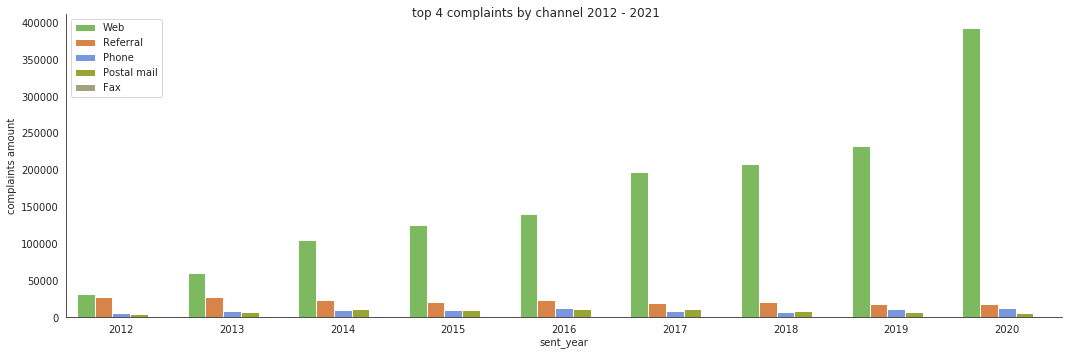

In [0]:
#group by channel by year to get the top 4 ranked complaints amount in each year
genBarchart("channel", "submitted_via")

###### 2.1.1.2 Which products get the most complaints? Have it changed over time? 
- Group count complaints by product by year

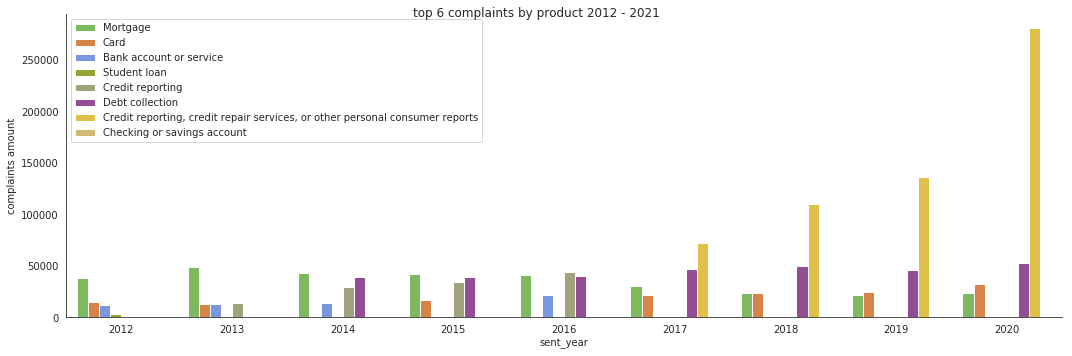

In [0]:
#show name and column name
genBarchart("product", "product_merged",6)

In [0]:
df_company = sqlContext.sql("SELECT company,count(1) as count " + \
               "FROM t_complaints WHERE product_merged like 'Credit reporting%' " + 
               "GROUP BY company ").toPandas()

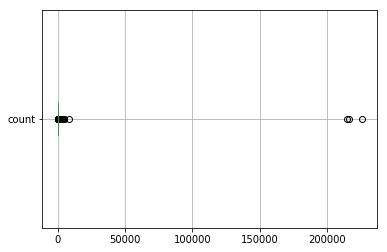

In [0]:
#df_company[['count']].hist(alpha=0.75,bins=35,figsize=(12,6))
#df_company.hist(bins=20,alpha = 0.5) 
#df_company.plot(kind = 'kde', secondary_y=True) 
#df_company.boxplot(column=['count'], rot=65, fontsize=12)
df_company.plot.box(vert=False, grid = True)


###### 2.1.1.3 Where are the complaints from
From annually top N rank of complaints amount by states, we can see
- the amount of complaints are all increased during the analysis period
- compare to the other top-ranked states which have shown slowdown in total complaints since 2017, the FL states shows rapid growth during the period given.
- the top N ranked states chart shows that the amount of complaints in the state is proportional to that of the population

In [0]:
#show name and column name
genLinechart("state", "state",6)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-559632990898263> in <module> 
 1 #show name and column name 
 ----> 2 genLinechart ( "state" , "state" , 6 ) 

 <command-918820089232086> in genLinechart (name, group_field_name, top_n) 
 4 df = getRankByYear ( group_field_name ) 
 5 #begin year 
 ----> 6 year1 = years [ 0 ] ; 
 7 #end year 
 8 year2 = years [ - 1 ] 

 NameError : name 'years' is not defined

##### 2.1.2 complaints volumn by week by channel
This might be a guidance for the capacity allocation of the call center.

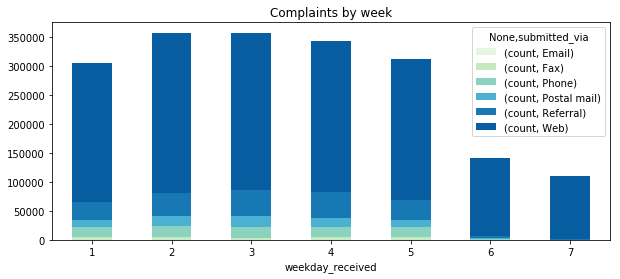

In [0]:
%matplotlib inline
#count complaints group by day of week
df_chart = sdf.groupBy("weekday_received","submitted_via")\
  .agg({"submitted_via":"count"})\
  .withColumnRenamed("count(submitted_via)", "count").toPandas()

# show week labels
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('')
df_chart.groupby(['weekday_received','submitted_via']).sum()\
  .unstack().plot(kind='bar',stacked=True,title='Complaints by week', \
                  colormap=ListedColormap(sns.color_palette("GnBu", 10)), rot=0, 
                  figsize=(10,4))
plt.show()

##### 2.1.3 how the company respond
- How many companies have ever chosen monetary relief to their customers.
The company handle the complaint in different ways, one of the ways is close with monetary relief.
What's the proportation of this way in the financial companies? Did that changed over the years.
- Which kind of product the companies prefer to give monetary relief for

In [0]:
#which products have closed the complaints by monetay relief, the proportation of monetary relief in total complaints of the company
#almost 1/3 complaints of the prepaid card product has been closed by monetary relief
display(sqlContext.sql("SELECT product," + \
               "max(case when company_response='Closed with monetary relief' then 1 else 0 end) as has_monetary_close" + 
               ",sum(case when company_response='Closed with monetary relief' then 1 else 0 end) as count_monetary_close "
               ",count(1) as total FROM t_complaints " + 
               "group by product ").filter("has_monetary_close=1 ")
              .withColumn("rate", F.col("count_monetary_close")/F.col("total")*100))

product,has_monetary_close,count_monetary_close,total,rate
Debt collection,1,3209,329509,0.9738732477716845
Payday loan,1,272,5523,4.924859677711389
Money transfers,1,636,5155,12.337536372453927
"Money transfer, virtual currency, or money service",1,1863,20246,9.201817642991209
Checking or savings account,1,15519,76440,20.302197802197803
Mortgage,1,9458,313179,3.0199981480239733
Prepaid card,1,1171,3776,31.01165254237288
Credit card or prepaid card,1,16619,97371,17.067710098489282
Credit reporting,1,753,139959,0.5380147043062611
Consumer Loan,1,2073,31423,6.597078573019763


In [0]:
#which companies have closed the complaints by monetay relief, the proportation of monetary relief in total complaints of the company
display(sqlContext.sql("SELECT company," + \
               "max(case when company_response='Closed with monetary relief' then 1 else 0 end) as has_monetary_close" + 
               ",sum(case when company_response='Closed with monetary relief' then 1 else 0 end) as count_monetary_close "
               ",count(1) as total FROM t_complaints where product='Prepaid card' " + 
               "group by company ").filter("has_monetary_close=1 "))

company,has_monetary_close,count_monetary_close,total
SYNCHRONY FINANCIAL,1,9,20
"BANK OF AMERICA, NATIONAL ASSOCIATION",1,7,55
"CITIBANK, N.A.",1,52,204
"Young America Holdings, LLC",1,1,2
First Data Corporation,1,1,31
Comerica,1,79,274
"Travelex NY, Inc.",1,1,3
CAPITAL ONE FINANCIAL CORPORATION,1,4,21
TD BANK US HOLDING COMPANY,1,5,13
FIRST HORIZON BANK,1,2,15


In [0]:
display(sqlContext.sql("SELECT * FROM t_complaints where company='Empowerment Ventures, LLC' " + 
               " AND product='Prepaid card' AND company_response='Closed with monetary relief'"))

date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,submitted_via,company_response,consumer_disputed,complaint_id,complaint_length,weekday_received,year_received,product_merged
2015-10-20,Prepaid card,ID prepaid card,Fraud or scam,,Rushcard did a system maintenance. While doing this maintenance I had a direct deposit go into my account that they wo n't release to me. The system has been down since XXXX/XXXX/15. I and others have not had access to our money before or after. Many of us like myself still after 9 days have no access to my money. You call the customer service line it hangs up on you. Or there is no answer while being on hold for hours at a time.,,"Empowerment Ventures, LLC",CA,952XX,Web,Closed with monetary relief,No,1616224,433,2,2015,Prepaid card
2015-10-22,Prepaid card,General purpose card,Unauthorized transactions/trans. issues,,"I have a Rushcard that I use to make Direct Deposits for on my payroll every 2 weeks. I received an email that they were having some maintenance done with their website on XXXX/XXXX/15. On XXXX/XXXX/15 there was another email stating to take any funds out of the card just in case it was needed while the maintenance was still in progress. I had no funds in there at the time. On Wednesday night XXXX/XXXX/15 my direct deposit was supposed to hit my account and then I usually withdraw the funds the next day. Since XXXX/XXXX/15, I have not been able to get my funds out of my card. My card says my account is inactive. The website will say my funds are there but then the day after it would show as XXXX dollars.When calling the company for more information it either rings and hangs up, or when they answer it is a "" our systems are down '' speech and unable to see your account please call tomorrow. I have relentlessly called them every day twice a day, on hold for 3 hours, emailed them over 20 times to their email address XXXXXXXXXXXX. I have XXXX messaged them over 30 times. Then on Sunday XXXX/XXXX/15, my account stated my deposit was there on another card I had previously but that one expired on XX/XX/2015. Since then they issued me a new caed which expires in 2018. This is still the case. I can not access my funds in any way at all. I get nothing but no explanations on the phone when you speak with agents. They are not in XXXX but outsourced from XXXX. They say they will call you back but they do n't. I still have not had any of my money returned to me since this has happened and there should not be any excuse for them not to update the card with the money unless they have taken it and are not saying so. My livelihood depends on my payroll checks, If I do n't have then bills will not get paid, there will be no food on the table, I take the bus to work so no bus fare, and my dog whom i love very much has no food to eat as well. I do n't have it as bad as the XXXX people who have been affected by this. But it is still my earnings that I worked hard for and I should not have to wait for them to give me what is rightfully mine. I called my HR payroll department and because it was posted as "" received fund '' from Rushcard as it seemed to be an open account at the time, they are unable to reverse the money to cut me a live check. I am one of the many who needs this to be corrected and as soon as I am able to I am going to take all of my money and burn the Rushcard into ashes. But in the meantime I still need my money and it has not been resolved. This is not how a business is run especially if involves money and banking. If this was just a technical issue then there are ways to get the money back. They could issue checks. They could issue money orders. But instead they ignore our emails, avoid our calls, lie to us on the media, and the contract says no arbitration allowed. There has to be some justice done to get this corrected.",,"Empowerment Ventures, LLC",NV,891XX,Web,Closed with monetary relief,No,1619658,2972,4,2015,Prep

The complaints closed by monetary relief and the total complaints by year

In [0]:
#what kinds of response
display(sqlContext.sql("SELECT year_received" + \
               ",SUM(CASE WHEN company_response='Closed with monetary relief' THEN 1 ELSE 0 END) AS monetary_close" + 
               ",COUNT(1) AS total FROM t_complaints " + 
               "GROUP BY year_received ORDER BY year_received"))

year_received,monetary_close,total
2012,6504,71758
2013,8810,107164
2014,9268,152042
2015,10386,167328
2016,11861,190139
2017,11498,238983
2018,11438,249786
2019,10881,269441
2020,12116,433533
2021,551,41484


In [0]:
#according to the above exploration, keep these columns for prediction
display(sqlContext.sql("SELECT company_response from " +\
                       " t_complaints  group by company_response"))

company_response
Untimely response
Closed with non-monetary relief
Closed without relief
In progress
Closed with monetary relief
Closed with explanation
Closed
Closed with relief
""


In [0]:
# is the 
df_company_response_by_year = pd.pivot_table(sdf.groupBy("year_received","company","company_response").count().toPandas(),\
               values = 'count', index=['year_received','company'], columns = 'company_response').reset_index()

In [0]:
df_tmp = sdf.select("company","product_merged","year_received","company_response").\
  where("company_response = 'Closed with monetary relief' or company_response = 'Closed with monetary relief'").\
  groupby("company","product_merged","year_received","company_response").count().toPandas()


In [0]:
df_product_relief = pd.pivot_table(df_tmp,\
               values = 'count', index=['year_received','company','product_merged'], columns = 'company_response').reset_index()
df_product_relief.sort_values("Closed with monetary relief",ascending=False)[:20]

company_response,year_received,company,product_merged,Closed with monetary relief
2241,2016,"CITIBANK, N.A.",Card,1653
3776,2018,"BANK OF AMERICA, NATIONAL ASSOCIATION",Checking or savings account,1215
5074,2020,"BANK OF AMERICA, NATIONAL ASSOCIATION",Checking or savings account,1059
4441,2019,"BANK OF AMERICA, NATIONAL ASSOCIATION",Checking or savings account,994
1533,2015,"CITIBANK, N.A.",Card,976
2167,2016,"BANK OF AMERICA, NATIONAL ASSOCIATION",Bank account or service,898
4045,2018,JPMORGAN CHASE & CO.,Checking or savings account,880
5119,2020,CAPITAL ONE FINANCIAL CORPORATION,Card,879
4691,2019,JPMORGAN CHASE & CO.,Checking or savings account,865
388,2013,"CITIBANK, N.A.",Card,844


In [0]:
df_company_response_by_year.sort_values("Closed with monetary relief",ascending=False)[:20].\
  pivot(index='year_received', columns='year_received', values='Closed with monetary relief').plot()

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-48726519123558> in <module> 
 1 df_company_response_by_year . sort_values ( "Closed with monetary relief" , ascending = False ) [ : 20 ] . \ 
 ----> 2 pivot ( index = 'year_received' , columns = 'year_received' , values = 'Closed with monetary relief' ) . plot ( ) 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in pivot (self, index, columns, values) 
 5626 def pivot ( self , index = None , columns = None , values = None ) : 
 5627 from pandas . core . reshape . pivot import pivot
 -> 5628 return pivot ( self , index = index , columns = columns , values = values ) 
 5629 
 5630 _shared_docs['pivot_table'] = """

 /databricks/python/lib/python3.7/site-packages/pandas/core/reshape/pivot.py in pivot (data, index, columns, values) 
 386 indexed = data._constructor_sliced(data[values].values,
 387 index=index)
 --> 388 return indexed . unstack ( columns ) 
 389 
 390 

 /databricks/python/lib/python3.7/site-packages/pandas/core/series.py in unstack (self, level, fill_value) 
 3299 """
 3300 from pandas . core . reshape . reshape import unstack
 -> 3301 return unstack ( self , level , fill_value ) 
 3302 
 3303 # ---------------------------------------------------------------------- 

 /databricks/python/lib/python3.7/site-packages/pandas/core/reshape/reshape.py in unstack (obj, level, fill_value) 
 394 unstacker = _Unstacker(obj.values, obj.index, level=level,
 395 fill_value = fill_value , 
 --> 396 constructor=obj._constructor_expanddim)
 397 return unstacker . get_result ( ) 
 398 

 /databricks/python/lib/python3.7/site-packages/pandas/core/reshape/reshape.py in __init__ (self, values, index, level, value_columns, fill_value, constructor) 
 98 self . index = index . remove_unused_levels ( ) 
 99 
 --> 100 self . level = self . index . _get_level_number ( level ) 
 101 
 102 # when index includes `nan`, need to lift levels/strides by 1 

 /databricks/python/lib/python3.7/site-packages/pandas/core/indexes/multi.py in _get_level_number (self, level) 
 1116 if ( count > 1 ) and not is_integer ( level ) : 
 1117 raise ValueError('The name %s occurs multiple times, use a '
 -> 1118 'level number' % level)
 1119 try : 
 1120 level = self . names . index ( level ) 

 ValueError : The name year_received occurs multiple times, use a level number

##### 2.1.4 What the consumers's voice about Credit reporting (NLP)
By taking some sampling data, we have seen what the data looks like.
- **complaint_what_happened** is the description of what that consumer complained. By applying nlp related analysis, can we find the sentiment of these records. This is all about complaints, but there usually exists different levels of severity. If we can analysis these levels, it might be useful for the future classification.
 - Clearing text from punctuation (regexp_replace)
 - Tokenization (Tokenizer)
 - Delete stop words (StopWordsRemover)
 - Stematization (SnowballStemmer)
 - Filtering short words

In [0]:
#count the complaints and complaints with narrative by product by sub product
display(sqlContext.sql("SELECT product_merged,sub_product,count(1) as count, " + \
          " sum(CASE WHEN complaint_what_happened !='' THEN 1 ELSE 0 END) as narrative_count FROM t_complaints WHERE " +\
          " product_merged like '%Credit%'  " +\
          " AND year_received>=2017 " +\
          " GROUP BY product_merged,sub_product " +\
          " ORDER BY 3 DESC "))

product_merged,sub_product,count,narrative_count
"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,621645,235500
Credit reporting,,16550,6239
"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,6327,3430
"Credit reporting, credit repair services, or other personal consumer reports",Credit repair services,1630,1055
"Credit reporting, credit repair services, or other personal consumer reports",Conventional home mortgage,1,1


What's the issues of **credit reporting** products

In [0]:
# sub_product is 'Credit reporting' since 2017
# as the words cloud resource
sdf_content_issue = sqlContext.sql("SELECT issue,sub_issue, " + \
          " count(1) as count,sum(CASE WHEN complaint_what_happened !='' THEN 1 ELSE 0 END) as narrative_count, " + \
          " sum(CASE WHEN company_response ='Closed with relief' THEN 1 ELSE 0 END) as relief_count " + \
          " FROM t_complaints WHERE sub_product = 'Credit reporting' " +\
          " AND year_received>=2017 GROUP BY issue,sub_issue ORDER BY 3 DESC")
display(sdf_content_issue)

issue,sub_issue,count,narrative_count,relief_count
Incorrect information on your report,Information belongs to someone else,253917,68259,0
Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,85101,41874,0
Incorrect information on your report,Account status incorrect,48923,22752,0
Incorrect information on your report,Account information incorrect,45437,21599,0
Improper use of your report,Credit inquiries on your report that you don't recognize,37317,17057,0
Problem with a credit reporting company's investigation into an existing problem,Investigation took more than 30 days,25723,8587,0
Incorrect information on your report,Personal information incorrect,20955,5737,0
Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,20766,8528,0
Improper use of your report,Reporting company used your report improperly,17463,7371,0
Incorrect information on your report,Old information reappears or never goes away,10963,5735,0


We see lots of the complaints close by monetary relief measure from column **company_response**
What's the monetary relief for

In [0]:
# sub_product is 'Credit reporting' since 2017
# as the words cloud resource
sdf_content_relief_issue = sqlContext.sql("SELECT issue,product_merged, " + \
          " count(1) as count,sum(CASE WHEN complaint_what_happened !='' THEN 1 ELSE 0 END) as narrative_count " + \
          " FROM t_complaints WHERE company_response like '%relief%' GROUP BY issue,product_merged ORDER BY 3 DESC")
display(sdf_content_relief_issue)

issue,product_merged,count,narrative_count
Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",55288,21050
Incorrect information on credit report,Credit reporting,27980,4834
Problem with a credit reporting company's investigation into an existing problem,"Credit reporting, credit repair services, or other personal consumer reports",15191,7823
"Loan modification,collection,foreclosure",Mortgage,14546,547
Managing an account,Checking or savings account,10750,3919
Cont'd attempts collect debt not owed,Debt collection,10506,2641
"Account opening, closing, or management",Bank account or service,10299,2015
"Loan servicing, payments, escrow account",Mortgage,10296,1342
Attempts to collect debt not owed,Debt collection,9921,5015
Communication tactics,Debt collection,8912,3361


In [0]:
# sub_product is 'Credit reporting' since 2017
# as the words cloud resource
sdf_content_relief_issue = sqlContext.sql("SELECT issue,sub_issue, " + \
          " count(1) as count,sum(CASE WHEN complaint_what_happened !='' THEN 1 ELSE 0 END) as narrative_count, " + \
          " sum(CASE WHEN company_response ='Closed with relief' THEN 1 ELSE 0 END) as relief_count " + \
          " FROM t_complaints WHERE year_received>=2017 GROUP BY issue,sub_issue ORDER BY 3 DESC")
display(sdf_content_relief_issue)

issue,sub_issue,count,narrative_count,relief_count
Incorrect information on your report,Information belongs to someone else,256139,69092,0
Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,87384,43309,0
Incorrect information on your report,Account status incorrect,52162,24091,0
Incorrect information on your report,Account information incorrect,48135,22684,0
Attempts to collect debt not owed,Debt is not yours,44454,20837,0
Trouble during payment process,,41255,19179,0
Improper use of your report,Credit inquiries on your report that you don't recognize,37946,17277,0
Written notification about debt,Didn't receive enough information to verify debt,30904,10903,0
Struggling to pay mortgage,,27297,10777,0
Problem with a credit reporting company's investigation into an existing problem,Investigation took more than 30 days,25846,8651,0


There's a big proportion of complaints are **information belongs to someone else**

According to the above result, sub-product **Credit reporting** has the largest proportion, and almost 1/3 of this kinds of complaints have narratives recorded. So we try to visualize this part of data by words cloud chart.

In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize

vstopwords = np.append(stopwords,["x","xx","xxx","xxxx","xxxxx","xxxxxxxx","xx/xx/xxxx","word","count"])
#extract content from specific field of the dataframe, and return 
def parseContent(df_story, field_name):
  #lower 
  df_story_clean = df_story.select("year_received",field_name, (F.lower(F.regexp_replace(field_name, 
                                                                         "[^a-zA-Z\\s]", "")).alias('out1')))
  #split story into words
  tokenizer = Tokenizer(inputCol="out1", outputCol="out2")
  #private infor has been replaced with x before the dataset published, such as date, name...
  #remove stop words
  stopWordsRemover = StopWordsRemover(inputCol='out2', outputCol='out3' ,stopWords=stopwords)
  #stem
  stemmer = SnowballStemmer('english')

  udf_stem = udf(lambda words: [stemmer.stem(word) for word in words if len(word)>3 and word in english_words ], ArrayType(StringType()))
  
  #pipeline
  pipeline = Pipeline(stages=[tokenizer, stopWordsRemover])
  return pipeline.fit(df_story_clean).transform(df_story_clean) \
      .select("year_received",field_name,"out3") \
      .drop("out1","out2") \
      .withColumn("words", udf_stem(F.col("out3"))).drop('out3')

In [0]:
#show words cloud
def show_words_cloud(sdf,title):
  df = sdf.select(explode("words").alias('word')).\
  groupby('word').count().sort(F.desc("count")).toPandas()  
  
  wc = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(df.to_string()) 
  
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.title(title)
  plt.show() 

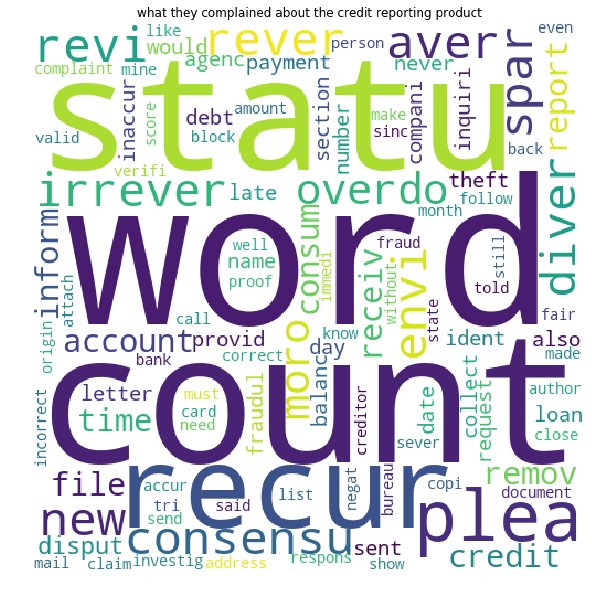

In [0]:
# sub_product is 'Credit reporting' since 2017
# as the words cloud resource
sdf_content = sqlContext.sql("SELECT year_received,complaint_what_happened " + \
          " FROM t_complaints WHERE " +\
          " sub_product = 'Credit reporting' AND product_merged like '%Credit%'  " +\
          " AND year_received>=2017 AND complaint_what_happened!='' ")
#parse the text of this dataset
df_words = parseContent(sdf_content,"complaint_what_happened")
#show words lcoud
show_words_cloud(df_words,"what they complained about the credit reporting product")

...................

In [0]:
sdf_content = sqlContext.sql("SELECT year_received,concat(issue,sub_issue,product,sub_product) AS issues " + \
          " FROM t_complaints WHERE " +\
          " product_merged like '%Credit%'  " +\
          " AND year_received>=2017")


In [0]:
display(sqlContext.sql("SELECT issue,sub_issue,count(1) as count " + \
          " FROM t_complaints WHERE " +\
          " product_merged like '%Credit%'  " +\
          " AND year_received>=2017 GROUP BY issue,sub_issue"))

issue,sub_issue,count
Credit monitoring or identity theft protection services,Problem canceling credit monitoring or identify theft protection service,964
Incorrect information on your report,Account information incorrect,45437
Credit monitoring or identity theft protection services,Received unwanted marketing or advertising,241
Credit monitoring or identity protection,Billing dispute,93
Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,85101
Identity theft protection or other monitoring services,Problem with product or service terms changing,94
Problem with fraud alerts or security freezes,,9374
Credit monitoring or identity theft protection services,Didn't receive services that were advertised,724
Problem with a credit reporting company's investigation into an existing problem,Problem with personal statement of dispute,5513
Incorrect information on credit report,Information is not mine,4256


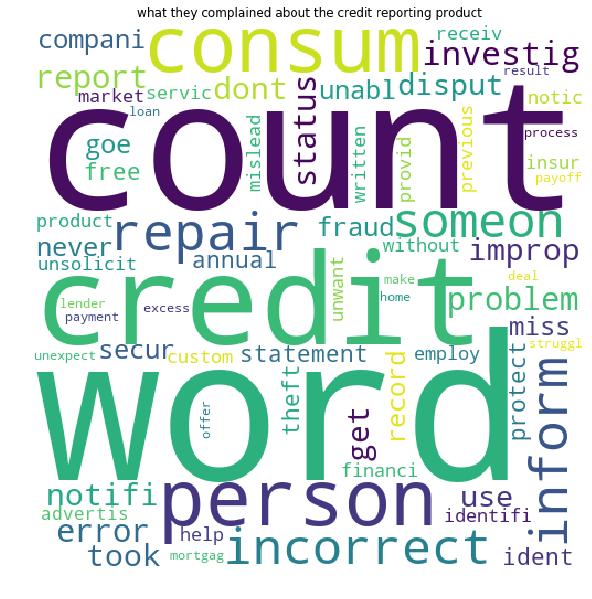

In [0]:
#display(sdf_content)
df_words = parseContent(sdf_content,"issues")
show_words_cloud(df_words,"what they complained about the credit reporting product")

In [0]:
# sub_product is 'Credit reporting' since 2017
# as the words cloud resource
sdf_content = sqlContext.sql("SELECT year_received,complaint_what_happened " + \
          " FROM t_complaints WHERE " +\
          " product_merged = 'Student loan'  " +\
          " AND year_received=2021 AND complaint_what_happened!='' ")
#parse the text of this dataset
df_words = parseContent(sdf_content,"complaint_what_happened")
#show words lcoud
show_words_cloud(df_words,"what they complained about the credit reporting product")

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 

 Py4JJavaError : An error occurred while calling o15535.select.
: org.apache.spark.sql.AnalysisException: cannot resolve '`year_received`' given input columns: [issues];;
'Project ['year_received, issues#3947, lower(regexp_replace(issues#3947, [^a-zA-Z\s], )) AS out1#3949]
+- Project [issues#3947]
 +- Filter ((year_received#2185 >= 2017) && product_merged#2207 LIKE %Credit%)
 +- Project [concat(issue#2093, sub_issue#2094, product#2091) AS issues#3947, year_received#2185, product_merged#2207]
 +- Project [date_received#2090, product#2091, sub_product#2092, issue#2093, sub_issue#2094, complaint_what_happened#2095, company_public_response#2096, company#2097, state#2098, zip_code#2099, submitted_via#2102, company_response#2104, consumer_disputed#2106, complaint_id#2107, complaint_length#2144, weekday_received#2164, year_received#2185, product_merged#2207]
 +- Project [date_received#2090, product#2091, sub_product#2092, issue#2093, sub_issue#2094, complaint_what_happened#2095, company_public_response#2096, company#2097, state#2098, zip_code#2099, tags#2100, consumer_consent_provided#2101, submitted_via#2102, date_sent_to_company#2103, company_response#2104, timely#2105, consumer_disputed#2106, complaint_id#2107, complaint_length#2144, weekday_received#2164, year_received#2185, CASE WHEN Contains(product#2091, Credit card) THEN Card ELSE product#2091 END AS product_merged#2207]
 +- Project [date_received#2090, product#2091, sub_product#2092, issue#2093, sub_issue#2094, complaint_what_happened#2095, company_public_response#2096, company#2097, state#2098, zip_code#2099, tags#2100, consumer_consent_provided#2101, submitted_via#2102, date_sent_to_company#2103, company_response#2104, timely#2105, consumer_disputed#2106, complaint_id#2107, complaint_length#2144, weekday_received#2164, year(date_received#2090) AS year_received#2185]
 +- Project [date_received#2090, product#2091, sub_product#2092, issue#2093, sub_issue#2094, complaint_what_happened#2095, company_public_response#2096, company#2097, state#2098, zip_code#2099, tags#2100, consumer_consent_provided#2101, submitted_via#2102, date_sent_to_company#2103, company_response#2104, timely#2105, consumer_disputed#2106, complaint_id#2107, complaint_length#2144, date_format(cast(date_received#2090 as timestamp), u, Some(Etc/UTC)) AS weekday_received#2164]
 +- Project [date_received#2090, product#2091, sub_product#2092, issue#2093, sub_issue#2094, complaint_what_happened#2095, company_public_response#2096, company#2097, state#2098, zip_code#2099, tags#2100, consumer_consent_provided#2101, submitted_via#2102, date_sent_to_company#2103, company_response#2104, timely#2105, consumer_disputed#2106, complaint_id#2107, length(complaint_what_happened#2095) AS complaint_length#2144]
 +- Filter AtLeastNNulls(n, complaint_id#2107,issue#2093,product#2091,date_received#2090,company#2097,state#2098,submitted_via#2102)
 +- Filter (((cast(date_received#2090 as string) > 2011-12-31) && NOT (state#2098 = )) && NOT (state#2098 = UNITED STATES MINOR OUTLYING ISLANDS))
 +- Relation[date_received#2090,product#2091,sub_product#2092,issue#2093,sub_issue#2094,complaint_what_happened#2095,company_public_response#2096,company#2097,state#2098,zip_code#2099,tags#2100,consumer_consent_provided#2101,submitted_via#2102,date_sent_to_company#2103,company_response#2104,timely#2105,consumer_disputed#2106,complaint_id#2107] json

	at org.apache.spark.sql.catalyst.analysis.package$AnalysisErrorAt.failAn

#### 3.1 Machine learning

##### 3.1.1 training and testing set

In [0]:
display(sdf_ml)

label,complaint_length,features
0.0,98,"List(0, 638, List(11, 340, 417, 577), List(1.0, 1.0, 1.0, 1.0))"
1.0,0,"List(0, 638, List(1, 335, 411, 583), List(1.0, 1.0, 1.0, 1.0))"
0.0,395,"List(0, 638, List(15, 340, 419, 584), List(1.0, 1.0, 1.0, 1.0))"
0.0,852,"List(0, 638, List(24, 343, 417, 576), List(1.0, 1.0, 1.0, 1.0))"
0.0,986,"List(0, 638, List(3, 335, 415, 576), List(1.0, 1.0, 1.0, 1.0))"
0.0,2399,"List(0, 638, List(3, 335, 415, 579), List(1.0, 1.0, 1.0, 1.0))"
0.0,0,"List(0, 638, List(1, 335, 411, 576), List(1.0, 1.0, 1.0, 1.0))"
0.0,0,"List(0, 638, List(46, 341, 463, 586), List(1.0, 1.0, 1.0, 1.0))"
0.0,127,"List(0, 638, List(29, 335, 411, 577), List(1.0, 1.0, 1.0, 1.0))"
0.0,0,"List(0, 638, List(1, 335, 411, 577), List(1.0, 1.0, 1.0, 1.0))"


In [0]:
train_sdf, test_sdf = sdf_ml.randomSplit([0.8, 0.2], seed=2021)

##### 3.1.2 LogisticRegression
- Create a model using LinearRegression, fit the training model
- print the summary stats of the model,

In [0]:
display(sdf_ml)

label,complaint_length,features
0.0,98,"List(0, 638, List(11, 340, 417, 577), List(1.0, 1.0, 1.0, 1.0))"
1.0,0,"List(0, 638, List(1, 335, 411, 583), List(1.0, 1.0, 1.0, 1.0))"
0.0,395,"List(0, 638, List(15, 340, 419, 584), List(1.0, 1.0, 1.0, 1.0))"
0.0,852,"List(0, 638, List(24, 343, 417, 576), List(1.0, 1.0, 1.0, 1.0))"
0.0,986,"List(0, 638, List(3, 335, 415, 576), List(1.0, 1.0, 1.0, 1.0))"
0.0,2399,"List(0, 638, List(3, 335, 415, 579), List(1.0, 1.0, 1.0, 1.0))"
0.0,0,"List(0, 638, List(1, 335, 411, 576), List(1.0, 1.0, 1.0, 1.0))"
0.0,0,"List(0, 638, List(46, 341, 463, 586), List(1.0, 1.0, 1.0, 1.0))"
0.0,127,"List(0, 638, List(29, 335, 411, 577), List(1.0, 1.0, 1.0, 1.0))"
0.0,0,"List(0, 638, List(1, 335, 411, 577), List(1.0, 1.0, 1.0, 1.0))"


In [0]:
from pyspark.ml.regression import LinearRegression

lr1 = LinearRegression(featuresCol = 'features',labelCol='label', maxIter=10)
lr_model1 = lr1.fit(train_sdf)

In [0]:
trainingSum = lr_model1.summary
print("RMSE: %f" % trainingSum.rootMeanSquaredError)
print("r2: %f" % trainingSum.r2)

RMSE: 0.823276
r2: 0.073041

##### 3.1.3 Evaluate the model

##### 3.1.4 Hyperparameter tuning

In [0]:
#api https://spark.apache.org/docs/latest/ml-tuning.html
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

lr = LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator)
"""
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
    .build()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
"""
cv_model = cv.fit(train_sdf)
#best model parameter
print(cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)])


In [0]:
#https://spark.apache.org/docs/latest/ml-tuning.html
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100,50]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_sdf)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test_sdf)

In [0]:
#spark pipeline 
#http://kuanliang.github.io/2016-06-07-SparkML-pipeline/
tokenizer = Tokenizer(inputCol="seq", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(labelCol="class", regParam)
tokenizer.transform(training).show()

hashingTF.transform(tokenizer.transform(training)).show()
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
paraGrid = ParamGridBuilder().addGrid(
    hashingTF.numFeatures, [10, 100, 1000]
).addGrid(
    lr.regParam, [0.1, 0.01, 0.001]
).build()
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paraGrid,\
                    evaluator=BinaryClassificationEvaluator(labelCol="class", metricName="areaUnderPR"),\
                    numFolds=2)
cv_model = cv.fit(training)

cv_model.bestModel
cv_model.bestModel.stages
for stage in cv_model.bestModel.stages:
    print 'stage: {}'.format(stage)
    print stage.params
    print '\n'
    
stage1.getNumFeatures()
stage2.intercept
stage2.weights
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cv_model.transform(test)
selected = prediction.select('seq', 'probability', 'prediction')


##### 3.1.5 Other models 
- Random Forest
- Decision Tree

In [0]:
#https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score
import sklearn 
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=50)
rfModel = rf.fit(train)
predictions_train = rfModel.transform(train_sdf)

y_true = predictions_train.select(['label']).collect()
y_pred = predictions_train.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

In [0]:

train_data, test_data = df_features.randomSplit([0.6,0.4])

dtc = DecisionTreeClassifier(featuresCol='features',labelCol='d')

dtcModel = dtc.fit(train_data)

predictions = dtcModel.transform(test_data)

##### 1.1.1 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.   + population
- input:big company, date, product type,least complained state
- output: state

##### 1.1.2 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.  + population
- input:product,max complained state name, big company, date
- output: state
complaints rate!!!!不适合发布新产品